<h1> Coding Challenge: Fraud detection </h1>
    
<h2>objectif: </h2>
Sur la base d'un dataset de transactions, évaluer si un utilisateur va commettre une fraude ou non.
Les données sources sont les fichiers data.csv (historique de transactions) et country.csv (correspondance entre pays et adresses IP)

<h3>Approche / questions: </h3>
    
    1) For each user, determine her country based on the numeric IP address.
    
    2) Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

    3) Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

    4) Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?
 

<H2> STEP 1 => charger les données et enrichir avec le pays</h2>

In [ ]:
import pandas as pd
data = pd.read_csv("data.csv")
countries = pd.read_csv("country.csv")

In [ ]:
# enrichissement de "data" avec le nom du pays correspondant a l'IP
def country_finder(ip):
    ip = float(ip)
    try:
        country = countries.loc[(ip > countries.lower_bound_ip_address) & (ip < countries.upper_bound_ip_address ),"country"].values[0]
        return country
    except:
        return "not_found"
    
data["country"] = [country_finder(r) for r in data.ip_address]


<h3> L'ajout des pays est fait cependant on constate ci dessous que pour + de 21k enregistrements aucun pays n'a pu être déterminé. Pour l'instant ces enregistrements sont conservés, nous réévaluerons plus tard s'il est préférable de les éliminer pour optimiser le modèle </h3>

In [50]:
data.groupby("country").count()["user_id"].sort_values(ascending = False).head()

country
United States     58049
not_found         21966
China             12038
Japan              7306
United Kingdom     4490
Name: user_id, dtype: int64

<h2>Step 2 => construction d'un modèle de prédiction</h2>


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


*Note:
on va utiliser un algorythme de type random_forest car cet algorythme a l'avantage d'être transparent et explicite dans son mécanisme de prédiction.
A ce stade on conserve la dataset fourni sans + d'optimisation, avec néanmoins une exclusion des colonnes ip_address (remplacée par la pays).
On verra dans un deuxième temps si le résultat peut être améliorer avec une préparation + spécifique de la donnée.*

In [116]:
X = data.drop(["class", "ip_address", "signup_time", "purchase_time"], axis = 1)
y = data.loc[:,"class"]

# le fit devrait en théorie etre fait sur la donnée de train uniquement, mais en théorie nous devrions disposer également d'une base produit complete de référence. Aussi je retiens le jeu de données complets pour le fit
X["device_id"] = le.fit_transform(X.device_id)
X["source"] = le.fit_transform(X.source)
X["browser"] = le.fit_transform(X.browser)
X["sex"] = le.fit_transform(X.sex)
X["country"] = le.fit_transform(X.country)

X_train, X_test, y_train, y_test = train_test_split(X,y)


from sklearn import preprocessing
le = preprocessing.LabelEncoder()               


from sklearn.tree import DecisionTreeClassifier as DTClass
from sklearn.model_selection import cross_val_score

cv_fold = 5
model = DTClass()
scores = cross_val_score(model, X_train, y_train, cv=cv_fold)

*Note:
l'entrainement du modèle sur les données brutes fournit un résultat de prédiction juste à environ 89%, comme on peut le voir sur le graph ci dessous*

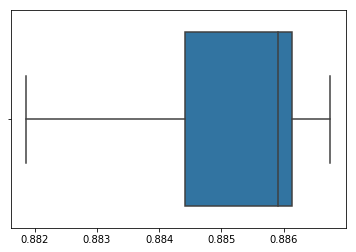

In [117]:
sns.boxplot(scores)

*on peut par ailleurs visualiser le chemin emprunté par l'arbre pour arriver a ces prédictions*

In [118]:
''' a completer

from graphviz import Source
from sklearn import tree
from IPython.display import SVG

# application de l'encodate variable au jeu de test

X_test["device_id"] = le.transform(X_test.device_id)
X_train["source"] = le.transform(X_test.source)
X_train["browser"] = le.transform(X_test.browser)
X_train["sex"] = le.transform(X_test.sex)
X_train["country"] = le.transform(X_test.country)


graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))
'''


' a completer\n\nfrom graphviz import Source\nfrom sklearn import tree\nfrom IPython.display import SVG\n\n# application de l\'encodate variable au jeu de test\n\nX_test["device_id"] = le.transform(X_test.device_id)\nX_train["source"] = le.transform(X_test.source)\nX_train["browser"] = le.transform(X_test.browser)\nX_train["sex"] = le.transform(X_test.sex)\nX_train["country"] = le.transform(X_test.country)\n\n\ngraph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns))\nSVG(graph.pipe(format=\'svg\'))\n'

*Note:
on teste ce modèle sur un réel jeu de test*


In [122]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[31775,  2495],
       [ 1744,  1764]])